In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from warnings import filterwarnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

import seaborn as sns
from numpy import random

filterwarnings("ignore")

# Построение GLM с помощью библиотеки sklearn

Обобщённые линейные модели (GLM) расширяют модели линейной регрессии двумя способами: во-первых, предсказываемые значения $\hat{y}$ связаны с линейной комбинацией входных переменных $X$ через обратную функцию свзяи $g$ следующим образом: 
<br>
<br>
$$\hat{y}(\theta, X) = g(X\theta)$$
<br>
Во-вторых, квадратичная функция потерь заменяется на единичное отклонение распределения в экспоненциальном семействе.
<br><br>Характеристики некоторых распределений из экспоненциального семейства и их плотности вероятностей:

| Распределение |Обозначение|Параметры|Математическое <br>ожидание|Дисперсия|Целевая область|Единичное отклонение        |
|---------------|-----------|---------|||----------------|-----------|
| Нормальное|$N(\mu, \sigma^2)$|$\mu \in \mathbb{R}$<br>$\sigma>0$|$\mu$|$\sigma^2$| $y \in (-\infty, \infty)$| $(y-\hat{y})^2$           |
| Пуассоновское  |$P(\lambda)$|$\lambda \in (0, \infty)$|$\lambda$|$\lambda$| $y \in [0, \infty)$|$2(y \log{\frac{y}{\hat{y}}}-y+\hat{y})$          |
|Гамма|$Г(k, \theta)$|$k>0$<br>$\theta>0$|$k \theta$|$k \theta^2$|$y \in (0, \infty)$|$2(\log\frac{\hat{y}}{y}+\frac{y}{\hat{y}}-1)$          |
|Обратное Гауссовское|$IG(\mu, \lambda)$|$\mu>0$<br>$\lambda>0$|$\mu$|$\frac{\mu^3}{\lambda}$|$y \in (0, \infty)$|$\frac{(y-\hat{y})^2}{y\hat{y}^2}$      |

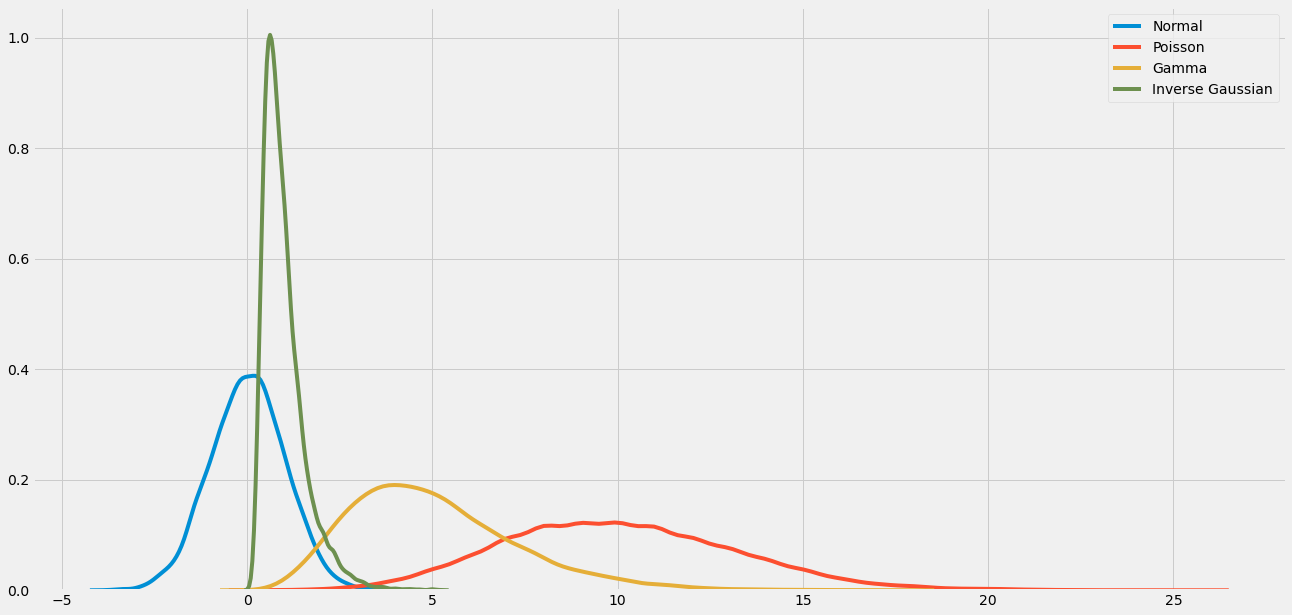

In [2]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(20,10))
sns.distplot(random.standard_normal(10000), hist=False, label='Normal')
sns.distplot(random.poisson(10, 10000), hist=False, label='Poisson')
sns.distplot(random.standard_gamma(5, 10000), hist=False, label='Gamma')
sns.distplot(random.wald(1, 3, 10000), hist=False, label='Inverse Gaussian')

plt.show()

Выбор распределения зависит от поставленной задачи:
<ul>
<li> Если целевые переменные являются вещественными или счётными, можно использовать Пуассоновское распределение с логистической функцией связи.
<li> Если целевые переменные положительные и неравномерные, можно использовать Гамма распределение с логистической функцией связи.
<li> Если целевые переменные кажутся более тяжёлыми, чем Гамма распределение, можно попробовать использовать Гауссовское распределение.
</ul>

<br>
<br> Примеры:
<ul>
<li> Сельское хозяйство/моделирование погоды: количество осадков за год (Пуассон), количество осадков в день (Гамма), общее количество осадков за год (комбинация Пуассона и Гаммы)
<li> Моделирование риска/ценообразование страхового полиса: количество претензий/страхований в год (Пуассон), стоимость одного страхования (Гамма), общая стоимость каждого страхования за год (комбинация Пуассона и Гаммы)
<li> Прогнозируемое обслуживание: количество остановок производства в год (Пуассон), продолжительность остановок производства (Гамма), общее время остановки производства за год (комбинация Пуассона и Гаммы)
</ul>

## TweedieRegressor

`TweedieRegressor` из библиотеки `sklearn.linear_model` реализует обобщённые линейные модели позволяю использовать любое из вышеупомянутых распределений. Распределение задаётся с помощью параметра `power`:
<br> `power = 0` Нормальное распределение. 
<br> `power = 1` Распределение Пуассона. Для удобства можно использовать `PoissonRegressor`, тем не менее это эквивалентно <br>`TweedieRegressor(power=1, link='log')`
<br> `power = (1, 2)` Комбинация Пуассоновского и Гамма распределения. 
<br> `power = 2` Гамма распределение. Для удобства можно использовать `GammaRegressor`, тем не менее это эквивалентно
<br>`TweedieRegressor(power=2, link='log')`
<br> `power = 3` Обратное Гауссовское распределение.
<br><br>Функция свзяи задаётся параметром `link`.
<br>`link: {'auto', 'identity', 'log'}, default='auto'`
<br>Параметр `'auto'` подбирает функцию связи основываясь на выбранном распределении:
<br>`'identity'` для Нормального распределения
<br>`'log'` для Пуассоновского, Гамма и Обратного Гауссовского распределений.

Следующий пример иллюстирует использование `PoissonRegressor` и `GammaRegressor` в наборе данных об исковых заявлениях к французской страховой компании. 
<br> Каждый элемент набора данных соответстует страховому полису, то есть договору между страховой компанией и страхователем.
<br><br>Наша цель заключается в том, чтобы предсказать ожидаемые затраты, то есть среднее количество исков за год, также известное как ожидаемая стоимость потерь.
<br><br>Есть несколько возможных вариантов сделать это, два из которых:
<br>1.Смоделировать число исков с помощью распределения Пуассона (частотная модель) и среднюю сумму искового заявления на один иск (сумму ущерба), с помощью Гамма распределения (модель ущерба), а затем перемножить прогнозы для получения общей суммы исков.
<br>2.Смоделировать общую сумму претензий напрямую с помощью комбинации Пуассоновского и Гамма распределений.

Набор данных *freMTPL2freq*, источник:https://www.openml.org/d/41214

In [4]:
df_freq = fetch_openml(data_id=41214, as_frame=True)['data'];
df_freq['IDpol'] = df_freq['IDpol'].astype(np.int);
df_freq.set_index('IDpol', inplace=True);
df_freq

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
IDpol,,,,,,,,,,,
1,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
3,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
5,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
10,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
11,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...
6114326,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
6114327,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
6114328,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82


В наборе данных имеется:
<br>*IDpol* - ID страхового полиса.<br>*ClaimNb* - количество исковых заявлений страхователя к страховщику с просьбой компенсировать ущерб, покрываемый страховкой, в течение действия страхового полиса.<br>*Exposure* - длительность действия страхового полиса.<br>*Area* - буквенный код географической области<br>*VehPower* - мощность автомобиля (категориальная переменная)<br>*VehAge* - возраст автомобиля, в годах<br>*DrivAge* - возраст водителя, в годах<br>*BonusMalus* - Бонус-малус (лат. "хороший-плохой"), тарифные коэффициенты, которые изменяют размер страховой премии, которую платит страхователь страховщику. От 50 до 320, 100, во Франции, означает "плохой".<br>*VehBrand* - марка автомобиля(категориальная переменная)<br>*VehGas* - тип двигателя: дизельный (Diesel), бензиновый (Regular).<br>*Density* - плотность населения в городе, в котором живёт водитель<br>*Region* - цифровой код департаментов Франции.

Набор данных *freMTPL2sev*, источник:https://www.openml.org/d/41215

In [5]:
df_sev = fetch_openml(data_id=41215, as_frame=True)['data']
df_sev['IDpol'] = df_sev['IDpol'].astype(np.int)
df_sev.set_index('IDpol', inplace=True)
df_sev

,ClaimAmount
IDpol,
1552,995.20
1010996,1128.12
4024277,1851.11
4007252,1204.00
4046424,1204.00
...,...
3254353,1200.00
3254353,1800.00
3254353,1000.00


В наборе данных имеется:
<br>*IDpol* - ID страхового полиса.<br>*ClaimAmount* - сумма искового заявления. <br><br>Найдём сумму исков для каждого ID:

In [6]:
df_sev = df_sev.groupby('IDpol').sum()
df_sev

,ClaimAmount
IDpol,
139,303.00
190,1981.84
414,1456.55
424,10834.00
463,3986.67
...,...
6113521,1324.40
6113793,1769.88
6113817,1288.28


Соединим два набора данных в одну таблицу:

In [7]:
df = df_freq.join(df_sev, how="left")
df["ClaimAmount"].fillna(0, inplace=True)
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93,0.0
6114327,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11,0.0
6114328,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82,0.0


Уберём кавычки со строковых полей, а так же сократим количество элементов до 60000:

In [8]:
for column_name in df.columns[df.dtypes.values == np.object]:
    df[column_name] = df[column_name].str.strip("'")
    df = df.iloc[:60000] 
    
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
129469,0.0,1.00,D,5.0,1.0,64.0,50.0,B2,Regular,546.0,R52,0.0
129472,0.0,1.00,B,6.0,3.0,58.0,50.0,B1,Diesel,58.0,R54,0.0
129475,0.0,0.49,E,6.0,4.0,55.0,50.0,B2,Diesel,4436.0,R25,0.0


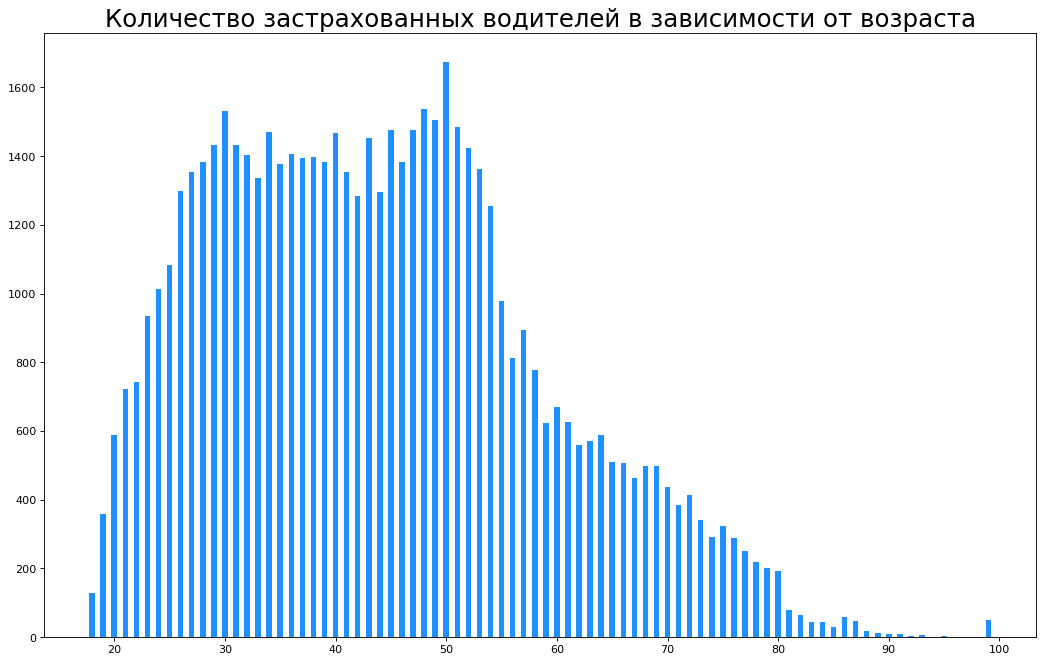

In [9]:
dt = df.groupby('DrivAge').size().reset_index(name='counts')
n = dt['DrivAge'].unique().__len__()+1

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(dt['DrivAge'], dt['counts'], color="dodgerblue", width=.5)

plt.title('Количество застрахованных водителей в зависимости от возраста', fontsize=22)
plt.show()

На гистограмме видно, что чаще всего страховой полис оформляют люди в возрасте 30 и 50 лет. При этом число застрахованых старше 80 лет резко падает. Примечательно, что есть 49 застрахованных водителей в возрасте 99 лет.

In [10]:
def plot_obs_pred(df, feature, weight, observed, predicted, y_label=None,
                  title=None, ax=None, fill_legend=False):
    """График наблюдений и прогноза - агрегируется по уровню объекта.

    Параметры
    ----------
    df : DataFrame
        Входные данные
    feature: str
        имя столбца из df который будет нанесён на график
    weight : str
        имя столбца df со значениями весов или периода
    observed : str
        имя столбца df с наблюдаемыми значениями 
    predicted : DataFrame
        dataframe, с тем же индексом, что и столбец df спрогнозируемыми значениями
    fill_legend : bool, default=False
        показывали ли легенду
    """
    # сбор наблюдений и прогноза по объекту
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )

## Извлечение основных характеристик и определение целевых переменных

Отфильтруем иски с нулевой стоимостью, так как модель суммы ущерба предполагает только положительные значения.

In [11]:
df.loc[(df['ClaimAmount'] == 0) & (df['ClaimNb'] >= 1), 'ClaimNb'] = 0

Исправим необоснованные данные, которые могут быть ошибкой данных и ограничим особенно большие исковые суммы

In [12]:
df['ClaimNb'] = df['ClaimNb'].clip(upper=4)
df['Exposure'] = df['Exposure'].clip(upper=1)
df['ClaimAmount'] = df['ClaimAmount'].clip(upper=200000)

### Предварительная обработка данных

Так как данные разного типа необходимо провести предварительную обработку. `ColumnTransformer` из библиотеки `sklearn.compose` позволяет применять различные преобразования для различных столбцов.<br>Так для столбцов `VehAge` и `DrivAge` применим `KBinsDiscretizer` для того, чтобы разбить данные на интервалы.<br>Для столбцов `VehBrand`, `VehPower`, `VehGas`, `Region`, `Area` применим `OneHotEncoder` для того, чтобы преобразовать категориальные переменные в числовой массив.<br>Столбец `BonusMalus` не изменяется. К столбцу `Density` применяем логарифмирование

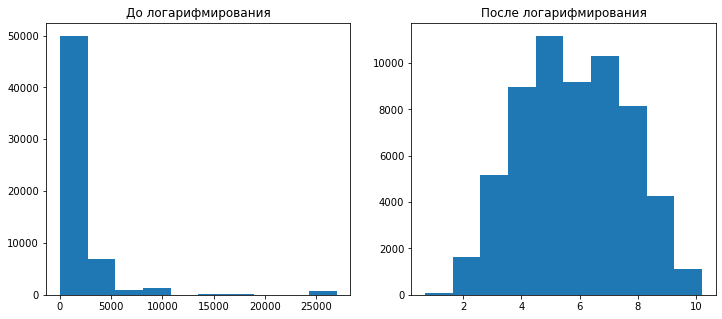

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

ax1.hist(df["Density"])
ax1.set_title('До логарифмирования')

ax2.hist(np.log(df["Density"]))
ax2.set_title('После логарифмирования')

plt.show()

In [14]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
    ],
    remainder="drop",
)

X = column_trans.fit_transform(df)

Страховые компании заинтересованы в моделировании ожидаемой стоимости потерь (PurePremium), это ожидаемая суммарная стоимость иска за период действия полиса для каждого страхователя 

In [15]:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

In [16]:
df.loc[df["PurePremium"] == max(df["PurePremium"])]

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium
IDpol,,,,,,,,,,,,,
53865,1.0,0.01,E,6.0,1.0,23.0,80.0,B2,Regular,2456.0,R11,183073.66,18307366.0


In [17]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

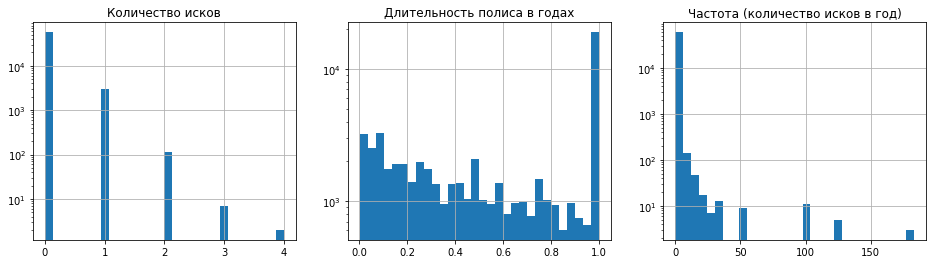

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Количество исков")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Длительность полиса в годах")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Частота (количество исков в год)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

In [19]:
def score_estimator(
    estimator, X_train, X_test, df_train, df_test, target, weights,
    tweedie_powers=None,
):
    """Оценка результатов разными метриками"""

    metrics = [
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Оценка модели состоящей из модели частотности и модели ущерба
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res

## Частотная модель - распределение Пуассона

Целевой переменной является частота попадания в аварии в течение года, то есть количество исковых заявлений в год.
<br><br>`PoissonRegressor` находится в библиотеке `sklearn.linear_model`. <br>`alpha` - сила регуляризации (`alpha = 0` - отсутствие регуляризации).<br>`max_iter` - максимальное число итераций.

In [20]:
df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

glm_freq = PoissonRegressor(alpha=1e-3, max_iter=400)
glm_freq.fit(X_train, df_train["Frequency"],
             sample_weight=df_train["Exposure"])

PoissonRegressor(alpha=0.001, max_iter=400)

In [21]:
scores = score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
mean abs. error     0.1706  0.1661
mean squared error  0.3041  0.3043


Можно визуально сравнить наблюдаемые и прогнозируемые значения, агрегированные по возрасту водителей (`DrivAge`).

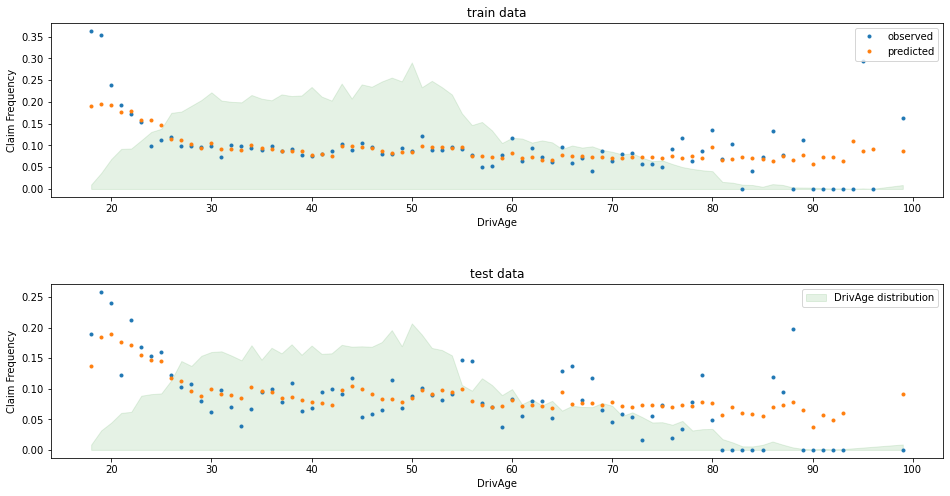

In [22]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

plot_obs_pred(
    df=df_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0]
)

plot_obs_pred(
    df=df_test,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1],
    fill_legend=True
)

Верхний график показывает то, как модель обучилась на обучающей выборке данных о частоте попадания в аварии, агрегированных по возрасту водителей. Нижний график это результаты полученные на тестовой выборке. Данные также агрегированны по возрасту водителей. Можно заметить, что водители в возрасте до 30 чаще попадают в аварии. 

## Модель ущерба - Гамма распределение

Можно показать эмпирически, что средняя сумма иска или сумма ущерба (AvgClaimAmount) примерно соответствует Гамма распределению.

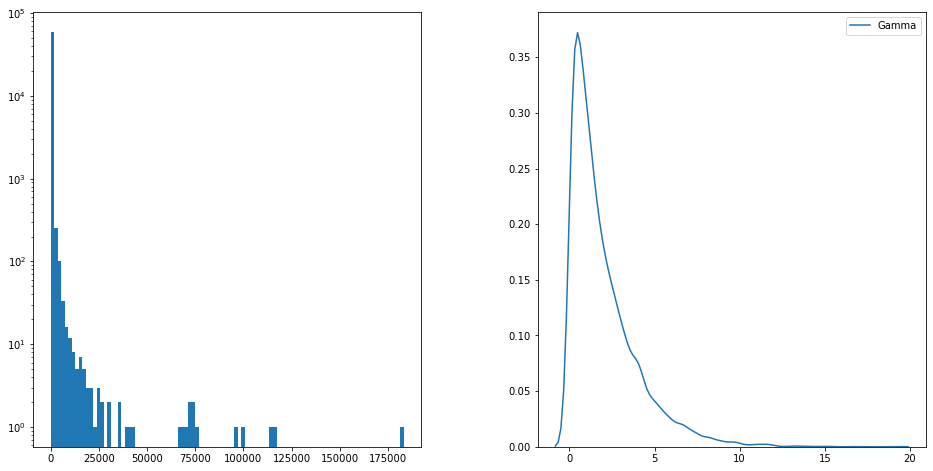

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax1.hist(df['AvgClaimAmount'], bins=100, log=True)


sns.distplot(random.gamma(1, 2, 10000), hist=False, label='Gamma')

plt.show()

Обучим линейную модель для ущерба с теми же характеристиками, что и для частотной модели.
<br><br>Отфильтруем данные `ClaimAmount == 0`, так как Гамма распределение определено на $(0, \infty)$.
<br>Будем использовать `ClaimNb` в качестве `sample_weight` чтобы учитывать страховые полиса, по которым имеется более одного иска.<br>У `GammaRegressor` такие же параметры, как у `PoissonRegressor`.

In [24]:
mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10., max_iter=10000)

glm_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

GammaRegressor(alpha=10.0, max_iter=10000)

In [25]:
scores = score_estimator(
    glm_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
mean abs. error     1.699197e+03  2.027923e+03
mean squared error  4.548147e+07  6.094863e+07


Результаты тестовых данных требуют осторожности, поскольку они хуже, чем тренировочные данные, что указывает на переобучение несмотря на сильную регуляризацию.
<br><br>Обратим внимание на то, что полученная модель представляет собой среднюю сумму иска на один иск. Она зависит от наличия хотя бы одного искового обращения и не может использоваться для прогнозирования средней суммы иска по полису в целом.

In [26]:
print("Среднее значение AvgClaim на полис:              %.2f "
      % df_train["AvgClaimAmount"].mean())
print("Среднее значение AvgClaim при условии NbClaim > 0:           %.2f"
      % df_train["AvgClaimAmount"][df_train["AvgClaimAmount"] > 0].mean())
print("Предсказанное среднее значение AvgClaim при условии NbClaim > 0: %.2f"
      % glm_sev.predict(X_train).mean())

Среднее значение AvgClaim на полис:              97.89 
Среднее значение AvgClaim при условии NbClaim > 0:           1899.60
Предсказанное среднее значение AvgClaim при условии NbClaim > 0: 1884.40


Можем визуально сравнить наблюдаемые и прогнозируемые значения, агрегированные по возрасту водителей (`DrivAge`).

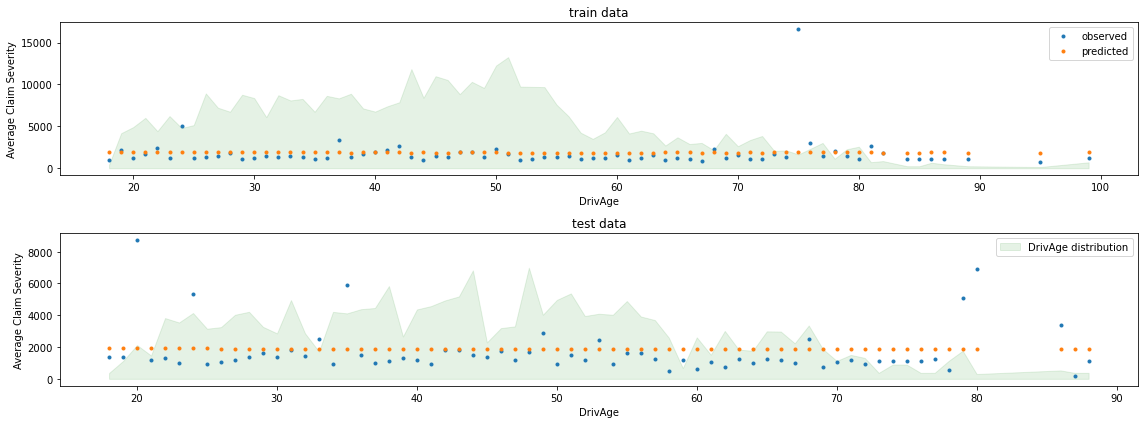

In [27]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(
    df=df_train.loc[mask_train],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_train[mask_train.values]),
    y_label="Average Claim Severity",
    title="train data",
    ax=ax[0],
)

plot_obs_pred(
    df=df_test.loc[mask_test],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_test[mask_test.values]),
    y_label="Average Claim Severity",
    title="test data",
    ax=ax[1],
    fill_legend=True
)
plt.tight_layout()

В целом возраст водителей (`DrivAge`) слабо влияет на сумму ущерба как в наблюдаемых, так и в прогнозных данных.

## Моделирование общей суммы потерь

Как упомянуто во введении, общая сумма потерь может быть смоделирована как произведение частотной моедли на модель ущерба. В качестве альтернативы можно напрямую смоделировать суммарные потер с помощью комбинации Пуассоновского и Гамма распределений с логарифмической функцией связи. Эта модель является частным случаем Tweedie GLM с параметром `power` $p \in (1, 2)$.
<br>В идеале значение параметра `power` нужно выбирать с помощью поиска по сетке, сводя к минимуму отрицательную логарифмическую функцию правдоподобия, но текущая реализация этого не позволяет.
<br><br>Сравним показатели обоих подходов.

In [28]:
glm_pure_premium = TweedieRegressor(power=1.9, alpha=.1, max_iter=10000)
glm_pure_premium.fit(X_train, df_train["PurePremium"],
                     sample_weight=df_train["Exposure"])

scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
)

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
)

scores = pd.concat([scores_product_model, scores_glm_pure_premium],
                   axis=1, sort=True,
                   keys=('Произведение моделей', 'TweedieRegressor'))
print("Оценка модели полученной произведением моделей и с помощью Tweedie Regressor")
with pd.option_context('display.expand_frame_repr', False):
    print(scores)

Оценка модели полученной произведением моделей и с помощью Tweedie Regressor
                   Произведение моделей               TweedieRegressor              
subset                            train          test            train          test
metric                                                                              
mean abs. error            3.246141e+02  3.468933e+02     3.202511e+02  3.397060e+02
mean squared error         1.469185e+08  3.325912e+07     1.469327e+08  3.325469e+07


В этом примере оба подхода дают сопоставимые показатели качества.
<br><br>Сравним две модели используя график аккумулированных исков: для каждой модели держатели полисов ранжируются от самых аккуратных к наиболее рискованным, а доля наблюдаемых накопленных исков наносится на ось y. Этот график называется упорядоченной кривой Лоренца.
<br>Коэффициент Джини (основанный на площади под кривой) может использоваться в качестве метрики выбора модели для количественной оценки способности модели ранжировать держателей полисов. (Этот показатель не отражает способность моделей делать точные прогнозы).

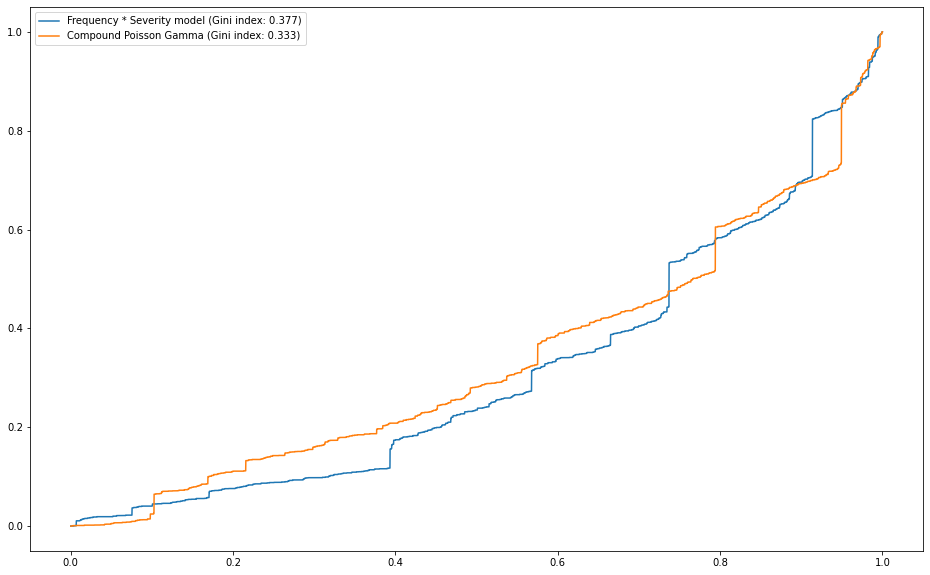

In [29]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(16, 10))

y_pred_product = glm_freq.predict(X_test) * glm_sev.predict(X_test)
y_pred_total = glm_pure_premium.predict(X_test)

for label, y_pred in [("Frequency * Severity model", y_pred_product),
                      ("Compound Poisson Gamma", y_pred_total)]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"])
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)
ax.legend(loc="upper left")
plt.plot();